In [979]:
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm

Establecer carpeta de destino para las tablas de resultados

In [980]:
path=r'E:\Ordenado\DATA ANALISYS\RTO tablas resultados'

Import Lista planillas 

In [981]:
lista_planillas=pd.read_csv('DATASET/Lista_planillas_COMPLETE.csv',
                            index_col=0,
                            #parse_dates=['Fecha'],
                            #infer_datetime_format=True)
                           )


Import Lista detalles

In [982]:
# Importar planillas de detalles
planilla_detalles_inc=pd.read_csv('DATASET/0.0.planillas.detalle.COMPLETE.csv',
                              index_col='Planilla',
                              dtype={'Modelo':'Int64','Planilla':'Int64'})
# Importar planillas de detalles faltantes 
planilla_detalles_faltante=pd.read_csv('DATASET/0.0.planillas.detalle.COMPLETE.faltante.csv',
                              index_col='Planilla',
                              dtype={'Modelo':'Int64','Planilla':'Int64'})

#Unir Planillas 
planilla_detalles=pd.concat([planilla_detalles_inc, planilla_detalles_faltante])

Import lista historico de revisiones 

In [983]:
historico_revisiones=pd.read_csv('DATASET/0.0.planillas.hist.COMPLETE.csv',
                                 index_col='Planilla',
                                 #parse_dates=['Fecha'],
                                 #infer_datetime_format=True)
                                )


## Anonimizar Datos 

Uso esta funcion cada vez que quiera mostrar una tabla que contenga informacion sensible de clientes 

In [1006]:
# Asigno nicknames utilizando el package faker.
from faker import Faker

def anon(dataframe,columna):
    # Asigno nicknames utilizando el package faker.
    faker = Faker()
    # seed the random generator to produce the same results
    Faker.seed(58874)
    dict_names = {name: faker.name() for name in dataframe[columna].unique()}
    dataframe[columna] = dataframe[columna].map(dict_names)



# Data Cleaning 

Lista de detalles

In [984]:
#Eliminar filas vacias
planilla_detalles.dropna(inplace=True)


#Cambiar nombre columnas
planilla_detalles.rename(columns={'Dominio:':'Dominio','Convenio:':'Convenio'},inplace=True)

#Eliminar columna innecesaria
planilla_detalles.drop(columns='Unnamed: 0',inplace=True)




lista historio de revisones

In [985]:
#Eliminar columna innecesaria
historico_revisiones.drop(columns='Unnamed: 0',inplace=True)

Lista de planillas

In [986]:
#Cambiar Fecha a formato datetime
lista_planillas['Fecha'] = pd.to_datetime(lista_planillas['Fecha'], format="%d/%m/%Y")

historico_revisiones['Fecha'] = pd.to_datetime(historico_revisiones['Fecha'], format="%d/%m/%Y")

#Crear Columnas : Anio,Mes,Mes_label, Anio y mes 
lista_planillas['Anio']=lista_planillas['Fecha'].dt.year

lista_planillas['Mes']=lista_planillas['Fecha'].dt.month

lista_planillas['Mes_label']=lista_planillas['Fecha'].dt.month_name(locale='es_ES')

lista_planillas['Anio y Mes']=lista_planillas['Anio'].astype(str)+lista_planillas['Mes'].astype(str)

# Mostrar CUIT en formato correcto 
lista_planillas['CUIT']=lista_planillas['CUIT'].astype('Int64')
#pd.options.display.float_format = '{:.0f}'.format

# Borrar espacios de Razon Social  
lista_planillas['Razón Social']=lista_planillas['Razón Social'].str.replace('\W', ' ', regex=True)

# Borrar asteriscos de Dominio
lista_planillas['Dominio']=lista_planillas['Dominio'].str.replace('\W', ' ', regex=True)




## Anonimizar Datos de clientes  .

Establecer una unica Razon Social para cada CUIT: 

Por errores de data entry, hay varios valores de razon social para un mismo CUIT. 

In [987]:
#Eliminar Cuit repetidos:
df_cuit_razon_social=lista_planillas[['CUIT','Razón Social']].drop_duplicates(subset=['CUIT']).sort_values('CUIT') 

#Usar CUIT como index
df_cuit_razon_social.set_index('CUIT',inplace=True)


#Transponer dataframe y pasarlo a lista de valores en el formato [{CUIT:Razon Social,CUIT:Razon Social}]
list_dict_cuit_razon_social=df_cuit_razon_social.T.to_dict(orient='records')


#El dicionario esta dentro de la lista, seleccionamos el indice [0] de la lista para obtenerlo
dict_cuit_razon_social=list_dict_cuit_razon_social[0]


In [988]:
#Creamos columna Razon Social Unica. Mapeamos los valores desde el diccionario 
lista_planillas['Razón Social Unica']=lista_planillas['CUIT'].map(dict_cuit_razon_social)

In [989]:
# Crear key unico  para todas las tablas 
lista_planillas['id']=lista_planillas.index.astype(str)+lista_planillas['Dominio']

planilla_detalles['id']=planilla_detalles.index.astype(str)+planilla_detalles['Dominio']

historico_revisiones['id']=historico_revisiones.index.astype(str)+historico_revisiones['Dominio']

## UNIR TODAS LAS TABLAS 

# Agregar Modelo a lista de planillas

In [992]:
#planilla de key : Dominio : Modelo 
filtro_modelo_null=planilla_detalles['Modelo'].notna()&(planilla_detalles['Modelo']>0)
planilla_detalles_sin_null=planilla_detalles[filtro_modelo_null].copy()
planilla_detalles_key=planilla_detalles_sin_null[['Modelo','Dominio']].drop_duplicates(subset=['Dominio'])

# Agregar con left merge 
lista_planillas=lista_planillas.reset_index().merge(planilla_detalles_key,how='left',left_on='Dominio',right_on='Dominio').copy()


In [993]:
#Agregar antiguedad al momento de la revision 
lista_planillas['antiguedad_revision']=lista_planillas['Anio']-lista_planillas['Modelo']

## Eliminar duplicados

In [994]:
lista_planillas.drop_duplicates(subset=('id'),inplace=True)

planilla_detalles.drop_duplicates(subset=('id'),inplace=True)

historico_revisiones.drop_duplicates(subset=('id'),inplace=True)

## Check modelos faltantes

In [995]:
Porcentaje=round(
                lista_planillas[lista_planillas['Modelo'].isna()]['Planilla'].count()/lista_planillas['Modelo'].count()*100,
                2)
print(f'Porcentaje de vehiculos sin informacion del año modelo : {Porcentaje}%')



Porcentaje de vehiculos sin informacion del año modelo : 4.85%


## Comenzemos con el analisis

# Flota total de cada Empresa

In [1007]:
#Eliminamos los duplicados de los pares Patente-CUIT . una misma patente pudo ser transferida por lo que si borramos todos los duplicados de patentes perderiamos esa informacion 
lista_planillas_dominio=lista_planillas.drop_duplicates(subset=['Dominio','CUIT'])

#Creamos una planilla agrupando y contando los dominios por Razon Social Unica.
vehiculos_por_cliente=lista_planillas_dominio.groupby('Razón Social Unica')[['Dominio']].count()

#Cambiamos el nombre de la columna por uno mas adecuado Revisiones Totales
vehiculos_por_cliente.rename(columns={'Dominio':'Flota Historica'},inplace=True)

# Anonimizamos la tabla para mostrar 
vehiculos_por_cliente.reset_index(inplace=True)

anon(vehiculos_por_cliente,'Razón Social Unica')

#Ordenamos los Clientes  por mayor numero de Revisiones totales 
vehiculos_por_cliente.sort_values('Flota Historica',ascending=False).head(10)



,Razón Social Unica,Flota Historica
3279,Edward Stafford,383
17636,Lisa Gutierrez,287
888,Jessica Cruz,286
53561,Gregory Smith,261
38212,Teresa Lin,209
11770,Laura Hayes,113
17368,Jacob Mann,110
15815,Samantha Choi,104
17634,Kimberly Levy,100
11787,Sara Warren,87


# Mejores clientes Historico

In [1008]:
#Creamos una planilla agrupando y contando los dominios por Razon Social Unica.
vehiculos_por_cliente=lista_planillas.groupby('Razón Social Unica')[['Dominio']].count()

#Cambiamos el nombre de la columna por uno mas adecuado Revisiones Totales
vehiculos_por_cliente.rename(columns={'Dominio':'Revisiones Totales'},inplace=True)

#Ordenamos los Clientes  por mayor numero de Revisiones totales 

# Anonimizamos la tabla para mostrar 
vehiculos_por_cliente.reset_index(inplace=True)

anon(vehiculos_por_cliente,'Razón Social Unica')

#Ordenamos los Clientes  por mayor numero de Revisiones totales 

vehiculos_por_cliente.sort_values('Revisiones Totales',ascending=False).head(10)

,Razón Social Unica,Revisiones Totales
17636,Lisa Gutierrez,1107
888,Jessica Cruz,1062
3279,Edward Stafford,1026
17368,Jacob Mann,984
17634,Kimberly Levy,689
53561,Gregory Smith,664
49087,Sheryl Gonzalez,630
17362,Tammie Willis,464
17361,David Terry,458
29045,Amanda Scott,449


# Mejores clientes por año 

In [1026]:
vehiculos_por_cliente_anual=pd.pivot_table(lista_planillas,index='Razón Social Unica',values='CUIT',columns='Anio',aggfunc='count')

In [1027]:
#reemplazo na por 0
vehiculos_por_cliente_anual.fillna(0,inplace=True)

In [1028]:
# Anonimizamos la tabla para mostrar 
vehiculos_por_cliente_anual.reset_index(inplace=True)

anon(vehiculos_por_cliente_anual,'Razón Social Unica')


vehiculos_por_cliente_anual.sort_values(2022,ascending=False).head(10)

Anio,Razón Social Unica,2014,2015,2016,2017,2018,2019,2020,2021,2022
17636,Lisa Gutierrez,17.0,29.0,44.0,65.0,135.0,239.0,140.0,223.0,215.0
3279,Edward Stafford,14.0,87.0,92.0,109.0,110.0,122.0,163.0,176.0,153.0
888,Jessica Cruz,24.0,125.0,125.0,142.0,117.0,134.0,127.0,133.0,135.0
17368,Jacob Mann,35.0,116.0,131.0,147.0,131.0,126.0,88.0,114.0,96.0
53561,Gregory Smith,22.0,60.0,92.0,89.0,70.0,76.0,70.0,90.0,95.0
27700,Jill Bonilla,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,75.0
49087,Sheryl Gonzalez,18.0,127.0,135.0,81.0,64.0,53.0,43.0,48.0,61.0
29045,Amanda Scott,6.0,62.0,55.0,50.0,67.0,51.0,52.0,50.0,56.0
11787,Sara Warren,3.0,34.0,37.0,46.0,26.0,32.0,44.0,35.0,54.0
17362,Tammie Willis,8.0,36.0,58.0,80.0,77.0,78.0,32.0,43.0,52.0


In [1037]:
#Lista de Empresas que fueron top en algun año 
lt=[]
for a in range (2014,2023):
    l=vehiculos_por_cliente_anual.nlargest(3,a).index.tolist()
    lt=lt+l
lt=set(lt)
#lt=[elem[:20]for elem  in lt]
lt=list(lt)


<AxesSubplot:title={'center':'Mejores Clientes Por Año'}, xlabel='Anio'>

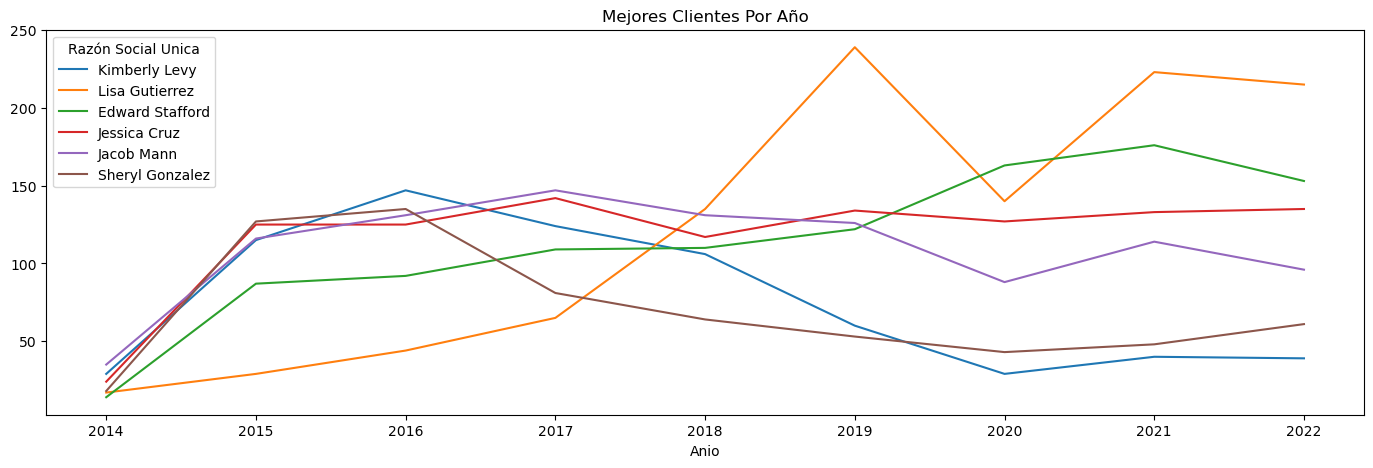

In [1045]:
# Transpongo la tabla para tener la fecha de index
#Filtro la tabla con la lista de empresas que fueron top 5 en algun año
vehiculos_por_cliente_anual_t=vehiculos_por_cliente_anual.loc[lt].set_index('Razón Social Unica').T
vehiculos_por_cliente_anual_t.plot(kind='line',figsize=(17,5),title='Mejores Clientes Por Año')

# Perdida de Clientes 

In [1086]:
#Lista de Dominios de revisiones dentro del taller :
lista_dominios_unicos=lista_planillas['Dominio'].drop_duplicates()

# Filtro la planilla historico_revisiones para tener solo los Dominios que alguna vez hayan realizado la revision en el taller
filtro_dominio=historico_revisiones['Dominio'].isin(lista_dominios_unicos)

historico_revisiones_taller=historico_revisiones[filtro_dominio].copy()


In [1087]:
#Calculo fecha min Proxima revision 

historico_revisiones_taller['Fecha_prox']=historico_revisiones_taller['Fecha']+datetime.timedelta(days=70)

#Calculo fecha min revision anterior 

historico_revisiones_taller['Fecha_ant']=historico_revisiones_taller['Fecha']-datetime.timedelta(days=70)

#crear columna Retencion_cliente dentro de la planilla perdida de clientes 
historico_revisiones_taller['Retencion_cliente']='Nada'



In [1088]:

# Primero Reinicio index para no perder el index anterior ( Planilla ) 
historico_revisiones_taller.reset_index(inplace=True) 

#Uso la columna id como index, ya que este no se repite
historico_revisiones_taller.set_index('id',inplace=True)

Condiciones para la nueva metrica de Retencion de clientes: 

Cuando NO es retencion de cliente :
    -Numero de taller siguiente es distinto
      
Cuando SI es retencion de cliente:
    -Numero de taller siguiente es el Mismo

Cuando Ignorar/no es ninguno:

    -La tecninca luego de un Condicional (si esta dentro de los 60 dias )
    
    -Si no hay tecnica siguiente 
    
    -la Tecnica luego de un Rechazado (dentro de los 60 dias)



Eliminar Tecnicas que se realizaron sin cargo

In [1089]:
# Crear tablas de Revisiones Condicionales en Nuestro taller

#Filtro revisiones condicionales     
filtro_condicional=historico_revisiones_taller['Resultado']=='Condicional'

#Filtro revisiones rechazadas 
filtro_rechazado=historico_revisiones_taller['Resultado']=='Rechazado'

#Filtro las revisiones condicionales que se hicieron en nuestro taller : Solo las revisiones en nuestro taller tendran la prox gratis 
filtro_taller=historico_revisiones_taller['Taller']==4


# Creo tabla temporal
temp=historico_revisiones_taller.loc[((filtro_condicional|filtro_rechazado)&filtro_taller),['Planilla','Resultado','Dominio','Fecha','Fecha_prox']]


# Creo tabla temporal de revisiones en nuestro Taller:Solo seran gratis tecnicas en nuestro taller 

temp_taller_4=historico_revisiones_taller[historico_revisiones_taller['Taller']==4]



In [1090]:
# import tqdm to see progress bar 
from tqdm.notebook import tqdm

In [1091]:
#Lista de Revisiones que SERIAN gratis en nuestro taller 
lista_rev_gratis=[]
for i in tqdm((temp.index)):
    #Planilla
    planilla=temp.loc[i,'Planilla']
    
    #Dominio
    dominio=temp.loc[i,'Dominio']
    #print(dominio)
   
    #Fecha 
    fecha=temp.loc[i,'Fecha']
    
    #Fecha prox
    fecha_prox=temp.loc[i,'Fecha_prox']
    
    #Filtro Dominio
    filtro_dominio=temp_taller_4['Dominio']==dominio
   
    
    #Filtro Fecha
    filtro_fecha=temp_taller_4['Fecha'].between(fecha,fecha_prox,inclusive='both')
    
    #Filtro planilla
    filtro_planilla=temp_taller_4['Planilla']!=planilla
    
    #REVISIONES QUE SERIAN GRATIS EN NUESTRO TALLER 
    revisiones_gratis=temp_taller_4[filtro_dominio&filtro_fecha&filtro_planilla]
    
    if not revisiones_gratis.empty:
        lista_rev_gratis.append(revisiones_gratis.index.tolist())
        
#print (lista_rev_gratis)

  0%|          | 0/17604 [00:00<?, ?it/s]

In [1092]:
# Convertir una lista de listas , a una lista

#con for loop 
lista_rev_gratis_flat = []
for sublist in lista_rev_gratis:
    for item in sublist:
        lista_rev_gratis_flat.append(item)

        # con list comprehension
#lista_rev_gratis_flat=[item for sublist in lista_rev_gratis for item in sublist]

Lista de revisiones que fueron pagadas 

In [1093]:
#Filtro revisiones pagas
filtro_revisiones_pagas=~historico_revisiones_taller.index.isin(lista_rev_gratis_flat)


retencion_clientes=historico_revisiones_taller.loc[filtro_revisiones_pagas].copy()

Cuando NO es retencion de cliente : -Numero de taller siguiente es distinto

Cuando SI es retencion de cliente: -Numero de taller siguiente es el Mismo

In [1094]:
# series shift : Tengo que hacer para slices de dataframe
# Pandas shift within a group 

#https://stackoverflow.com/questions/53335567/use-pandas-shift-within-a-group

retencion_clientes['taller_siguiente']=retencion_clientes.groupby('Dominio')['Taller'].shift(1)


Eliminar revisiones si fue la ultima tecnica 

In [1095]:
retencion_clientes.dropna(subset='taller_siguiente',inplace=True)

Retencion:

In [1096]:
retencion_clientes['Retencion_cliente']='asd'
for i in tqdm((retencion_clientes.index)):
    # Dar valores a retencion_cliente
    taller=retencion_clientes.loc[i,'Taller']
    taller_siguiente=retencion_clientes.loc[i,'taller_siguiente']

    if taller==4:
        if taller_siguiente==4:
            retencion_clientes.loc[i,'Retencion_cliente']='retencion'
        else:
            retencion_clientes.loc[i,'Retencion_cliente']='perdio'


    else:
        if taller_siguiente==4:
            retencion_clientes.loc[i,'Retencion_cliente']='gano'
        else:
            retencion_clientes.loc[i,'Retencion_cliente']='no gano'



  0%|          | 0/170084 [00:00<?, ?it/s]

In [1097]:
retencion_clientes.groupby('Retencion_cliente')['Resultado'].count()

Retencion_cliente
gano         24228
no gano      59545
perdio       27538
retencion    58773
Name: Resultado, dtype: int64

In [1098]:
retencion_clientes_pivot=pd.crosstab(index=retencion_clientes['Resultado'],
                                     values=retencion_clientes['Dominio'],
                                    columns=retencion_clientes['Retencion_cliente'],
                                    aggfunc='count')
retencion_clientes_pivot

Retencion_cliente,gano,no gano,perdio,retencion
Resultado,,,,
Apto,23412,44887,23139,52699
Condicional,702,12578,4297,5947
Rechazado,114,2080,102,127


In [1099]:
retencion_clientes_pivot_perc=pd.crosstab(index=retencion_clientes['Resultado'],
                                     values=retencion_clientes['Dominio'],
                                    columns=retencion_clientes['Retencion_cliente'],
                                    aggfunc='count',
                                    normalize='index')
retencion_clientes_pivot_perc.round(3)*100

Retencion_cliente,gano,no gano,perdio,retencion
Resultado,,,,
Apto,16.2,31.1,16.1,36.6
Condicional,3.0,53.5,18.3,25.3
Rechazado,4.7,85.8,4.2,5.2


In [1100]:
retencion_clientes_pivot_taller_4=retencion_clientes_pivot.iloc[:,[2,3]].copy()


In [1101]:
retencion_clientes_pivot_taller_4

Retencion_cliente,perdio,retencion
Resultado,,
Apto,23139,52699
Condicional,4297,5947
Rechazado,102,127


In [1102]:
retencion_clientes_pivot_taller_4_perc=pd.DataFrame()
retencion_clientes_pivot_taller_4_perc[['perdio', 'retencion']] = retencion_clientes_pivot_taller_4[['perdio', 'retencion']].apply(lambda x: x/x.sum(), axis=1)

In [1103]:
retencion_clientes_pivot_taller_4_perc.round(3)*100

,perdio,retencion
Resultado,,
Apto,30.5,69.5
Condicional,41.9,58.1
Rechazado,44.5,55.5


In [1104]:
retencion_tot=retencion_clientes_pivot_taller_4.sum()
retencion=((retencion_tot['retencion']/retencion_tot.sum())*100).round(1)
retencion

68.1

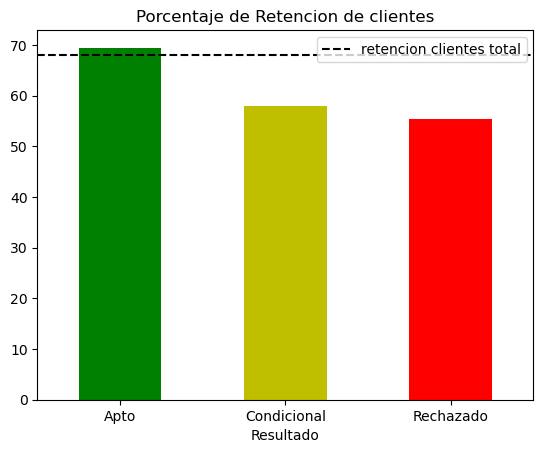

In [1105]:


(retencion_clientes_pivot_taller_4_perc['retencion']*100).plot.bar( title='Porcentaje de Retencion de clientes',rot=0,color=(['g','y','r']))

plt.xticks(rotation=0)

plt.axhline(y=retencion, color='k', linestyle='--')


labels = ["retencion clientes total"]
plt.legend(labels=labels)

plt.show()

El resultado de la revision tiene un impacto en la retencion de clientes.

Sin embargo la diferencia no es tan grande como ubiesemos estimados a priori 

Si solo evaluamos el efecto de las revisiones en LOS DEMAS talleres:

In [1106]:
retencion_clientes_pivot_taller_not_4=retencion_clientes_pivot.iloc[:,[0,1]].copy()


In [1107]:
retencion_clientes_pivot_taller_not_4

Retencion_cliente,gano,no gano
Resultado,,
Apto,23412,44887
Condicional,702,12578
Rechazado,114,2080


In [1108]:
retencion_clientes_pivot_taller_not_4_perc=pd.DataFrame()
retencion_clientes_pivot_taller_not_4_perc[['gano', 'no gano']] = retencion_clientes_pivot_taller_not_4[['gano', 'no gano']].apply(lambda x: x/x.sum(), axis=1)

In [1109]:
retencion_clientes_pivot_taller_not_4_perc.round(3)*100

,gano,no gano
Resultado,,
Apto,34.3,65.7
Condicional,5.3,94.7
Rechazado,5.2,94.8


In [1110]:
retencion_tot=retencion_clientes_pivot_taller_not_4.sum()
retencion=((retencion_tot['gano']/retencion_tot.sum())*100).round(1)
retencion

28.9

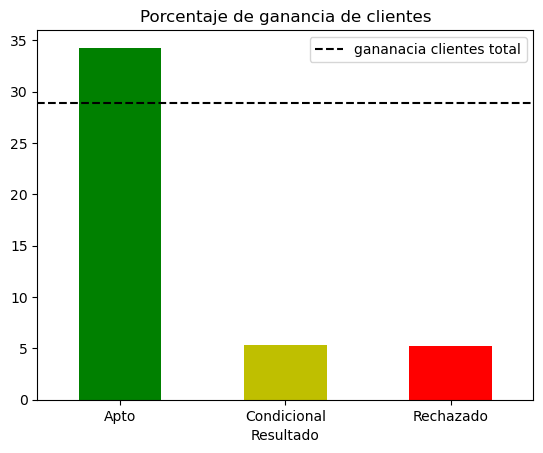

In [1111]:


(retencion_clientes_pivot_taller_not_4_perc['gano']*100).plot.bar( title='Porcentaje de ganancia de clientes',rot=0,color=(['g','y','r']))

plt.xticks(rotation=0)

plt.axhline(y=retencion, color='k', linestyle='--')


labels = ["gananacia clientes total"]
plt.legend(labels=labels)

plt.show()

EL dataset solo incluye vehiculos que hayan realizado la tecnica en nuestro taller en algun momento


Para evaluar la gananacia de clientes deberiamos contar con la base de datos de los vehiculos de los demas talleres.
 

# Dia con mas revisiones

In [1112]:
lista_planillas['day_of_week']=lista_planillas['Fecha'].dt.dayofweek+1

lista_planillas['day_name']=lista_planillas['Fecha'].dt.day_name(locale='es_ES')



In [1113]:
revisiones_por_dia=lista_planillas.groupby('day_of_week')[['Dominio']].count()


In [1114]:
horas_dia={1:9.5,2:9.5,3:9.5,4:9.5,5:9.5,6:4}

revisiones_por_dia['horas_por_dia']=revisiones_por_dia.index.map(horas_dia)

revisiones_por_dia['revisiones_por_hora']=(revisiones_por_dia['Dominio']/revisiones_por_dia['horas_por_dia']).round(0)


In [1115]:
revisiones_por_dia

,Dominio,horas_por_dia,revisiones_por_hora
day_of_week,,,
1,30374,9.5,3197.0
2,31480,9.5,3314.0
3,32957,9.5,3469.0
4,33138,9.5,3488.0
5,33366,9.5,3512.0
6,15542,4.0,3886.0


# Revisiones por dia agrupado por MES 

In [1116]:
lista_planillas.groupby('Mes')[['Dominio']].count()


,Dominio
Mes,
1,17654
2,14736
3,13865
4,11456
5,11503
6,12546
7,14836
8,14706
9,15182


# Hora de mas Revisiones 

In [1135]:
test=lista_planillas[['Inicio','Fin','Dominio','Fecha']].copy()
#Cambiar hora_resultado a formato datetime
test['Fin1']=pd.to_datetime(test['Fin'],format="%H:%M")
test['hora']=test['Fin1']
test.set_index('hora',inplace=True)
group=test.resample('15Min').count()[['Dominio']]


PLOT HISTOGRAM

In [1136]:
group_plot=group.query('hora>="1900-01-01 07:10:00"')

In [1137]:
group_plot.index=group_plot.index.time

Text(0, 0.5, 'Total de revisiones ')

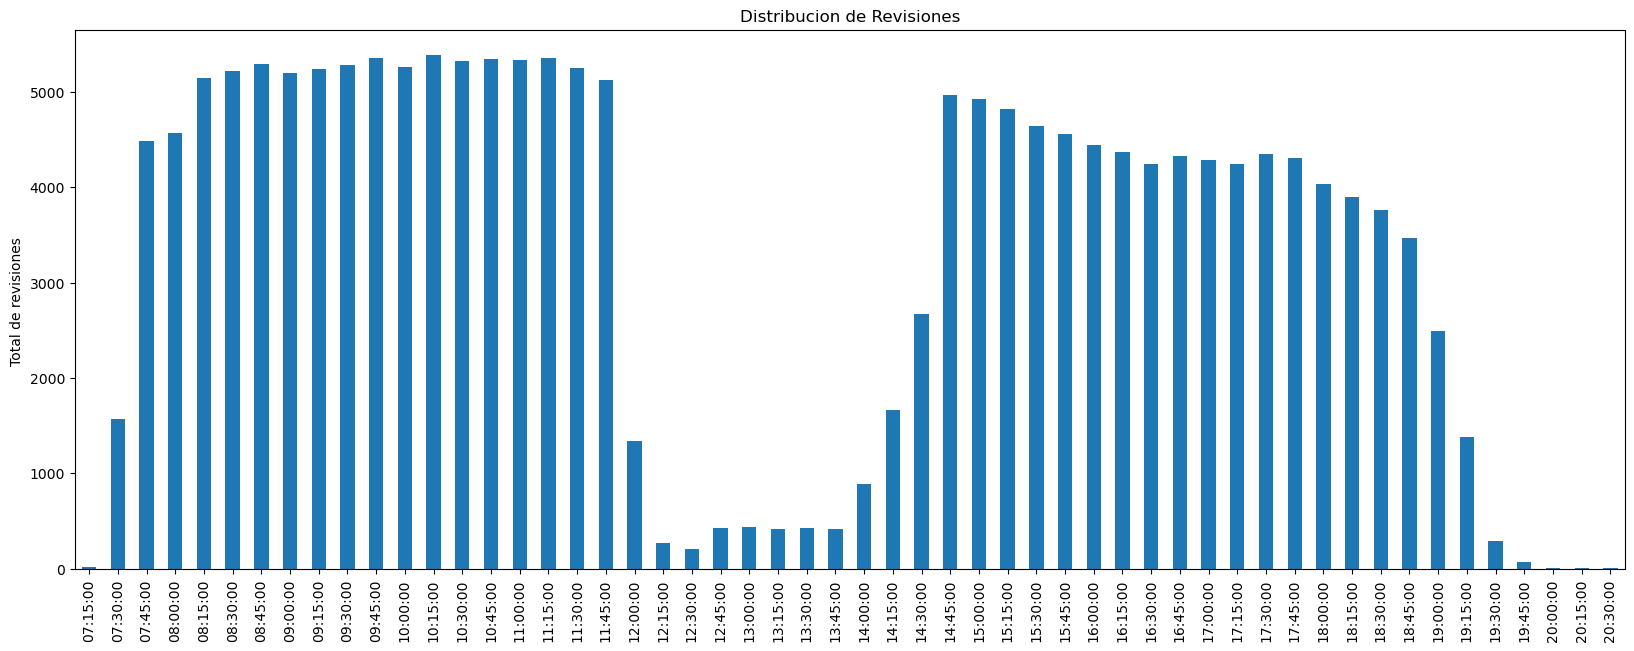

In [1138]:
group_plot.plot(kind='bar',figsize=(20,7),title='Distribucion de Revisiones',legend=False)

plt.ylabel('Total de revisiones ')

# Revision mas tarde y mas temprana 

In [1139]:
test.sort_values('Inicio',ascending=True).head(5).reset_index()[['Inicio','Fecha']]

,Inicio,Fecha
0,07:23,2017-03-16
1,07:23,2017-03-22
2,07:23,2017-03-28
3,07:24,2017-01-20
4,07:24,2019-01-24


In [1140]:
test.sort_values('Inicio',ascending=False).head(5).reset_index()[['Inicio','Fecha']]

,Inicio,Fecha
0,20:29,2015-01-13
1,20:29,2015-01-13
2,20:24,2015-01-13
3,20:21,2015-01-13
4,20:18,2019-01-07


# Anomalias mas comunes

In [1141]:
# Importar planillas de detalles
planilla_anomalias=pd.read_csv('DATASET/0.0.Anomalias.COMPLETE.csv',
                              index_col='Planilla')#,
                              #dtype={'Código':'str'})
                              


In [1142]:

#Eliminar columna innecesaria
planilla_anomalias.drop(columns='Unnamed: 0',inplace=True)

In [1143]:
planilla_anomalias.head()

,Código,Gravedad,Descripción,Observaciones
Planilla,,,,
1173505,20502,L,"Tren Delantero, Tren Trasero, Suspensión > Amortiguadores y Soportes > Fugas de líquido hidráulico",AMORTIGUADORES TRASEROS
1173505,20506,L,"Tren Delantero, Tren Trasero, Suspensión > Amortiguadores y Soportes > Desequilibrio mayor de 21%",AMORTIGUADORES TRASEROS
1173505,9010302,L,Carrocería > Exterior > Chapa Patente > Patente en mal estado y/o con fijación inadecuada,Patente en mal estado TRASERA
1124182,9010302,L,Carrocería > Exterior > Chapa Patente > Patente en mal estado y/o con fijación inadecuada,TRASERA
1053004,9010302,L,"Carrocería > Exterior > Chapa Patente > Faltante, Mal Estado, Fijación Inadecuada",ESTADO


In [1144]:


#cambiar nombre columna

planilla_anomalias.rename(columns={'Código':'Codigo','Descripción':'Descripcion'},inplace=True)

#Hacer NAN a los  codigos que no son numeros:
planilla_anomalias['Codigo']=pd.to_numeric(planilla_anomalias['Codigo'],errors='coerce')


#Eliminar NAN : 
planilla_anomalias.dropna(subset='Codigo',inplace=True)

#Hacer la columna codigo int
planilla_anomalias['Codigo']=planilla_anomalias['Codigo'].astype('Int64')



In [1145]:
#utilizo planilla temporal para utilizar la columna Descripcion y extraer la columna  Descripcion y categoria 
temp=planilla_anomalias.copy()

# Descripcion son las ultimas dos elementos 
planilla_anomalias['Descripcion']=temp['Descripcion'].str.split('>').str[-2:]




In [1146]:
#Uno los dos elementos en una sola linea, y en minusculas
planilla_anomalias['Descripcion'] = (planilla_anomalias['Descripcion'].apply(', '.join)).str.lower()

In [1147]:
#Categoria es el primer elemento 
planilla_anomalias['Categoria']=temp['Descripcion'].str.split('>').str[0]

#En minusculas
planilla_anomalias['Categoria'] =planilla_anomalias['Categoria'].str.lower()




In [1158]:
planilla_anomalias.groupby(['Codigo','Descripcion']).count().sort_values('Gravedad',ascending=False)[['Gravedad']].head()

,,Gravedad
Codigo,Descripcion,
60101,"neumáticos , estado general, cortes, erosiones, recapados, abombamientos, envejecimiento",24231
50103,"sistema de escape , fugas",8398
30409,"flexibles, pulmones, levas, campanas y cintas , campana, disco, mordazas, guarniciones, cintas, pastillas - desgaste visible o roturas",8011
30404,"prueba del sistema de freno , eficacia de frenado total menor al 45%",7176
3030302,"prestación del freno de servicio , eficiencia total menor al 45%",5849


## Anomalias Moderadas

In [1159]:
anomalias_pivot=planilla_anomalias.pivot_table(index=('Codigo','Descripcion'),
                                               columns='Gravedad',
                                               values='Categoria',
                                               aggfunc='count')

In [1160]:
anomalias_pivot.sort_values('M',ascending=False).head()[['M']]

,Gravedad,M
Codigo,Descripcion,
30404,"prueba del sistema de freno , eficacia de frenado total menor al 45%",6270.0
30403,"prueba del sistema de freno , asimetría de frenado en cada eje superior al 25%",5432.0
3030302,"prestación del freno de servicio , eficiencia total menor al 45%",5113.0
60101,"neumáticos , estado general, cortes, erosiones, recapados, abombamientos, envejecimiento",4464.0
30406,"prueba del sistema de freno , eficacia de freno de mano menor al 15%",4195.0


In [1152]:
anomalias_categoria_pivot=planilla_anomalias.pivot_table(index=('Categoria'),
                                               columns='Gravedad',
                                               values='Descripcion',
                                               aggfunc='count')

In [1161]:
anomalias_categoria_pivot.sort_values('M',ascending=False).head()[['M']]

Gravedad,M
Categoria,
sistema de frenos,18840.0
sistema eléctrico,17512.0
frenos,12287.0
carrocería,11180.0
sistema de dirección,10185.0


## Anomalias Graves

In [1162]:
anomalias_pivot.sort_values('G',ascending=False).head()[['G']]

,Gravedad,G
Codigo,Descripcion,
30404,"prueba del sistema de freno , eficacia de frenado total menor al 45%",906.0
3030302,"prestación del freno de servicio , eficiencia total menor al 45%",736.0
3030401,"prestación del freno de estacionamiento , eficiencia menor al 15%",431.0
30406,"prueba del sistema de freno , eficacia de freno de mano menor al 15%",380.0
10503,"alineación y dirección , desalineación en las ruedas directrices superior a 10 m/km (vehículos n1, m1)",300.0


In [1164]:
anomalias_categoria_pivot.sort_values('G',ascending=False).head()[['G']]

Gravedad,G
Categoria,
sistema de frenos,1405.0
frenos,1252.0
sistema de dirección,630.0
emisión de contaminantes,163.0
sistema eléctrico,161.0


## Anomalias Leves

In [1165]:
anomalias_pivot.sort_values('L',ascending=False).head()[['L']]

,Gravedad,L
Codigo,Descripcion,
60101,"neumáticos , estado general, cortes, erosiones, recapados, abombamientos, envejecimiento",19767.0
30409,"flexibles, pulmones, levas, campanas y cintas , campana, disco, mordazas, guarniciones, cintas, pastillas - desgaste visible o roturas",7605.0
50103,"sistema de escape , fugas",6948.0
90401,"parabrisas. inexistente, visibilidad defectuosa, roto , con defectos ó fisuras que no afecten a la seguridad",5200.0
70903,"sistema de iluminación y señalización exterior - luces de freno(stop) , intensidad luminosa menor o igual que luces de posición",4582.0


In [1166]:
anomalias_categoria_pivot.sort_values('L',ascending=False).head()[['L']]

Gravedad,L
Categoria,
sistema eléctrico,31421.0
carrocería,26873.0
neumáticos y llantas,20437.0
sistema de dirección,14855.0
emisión de contaminantes,14399.0


# Resultados segun antiguedad del vehiculo

In [1167]:
#eliminar anulados
test=lista_planillas[lista_planillas['Resultado']!='Anulado'].copy()

resultados_por_antiguedad=pd.crosstab(test['antiguedad_revision'],
                                      test['Resultado'],
                                      test['Dominio'],
                                      aggfunc='count',
                                     normalize='index')
porc_aptos=resultados_por_antiguedad.loc[:,['Apto']].round(3)*100

In [1168]:
porc_aptos_tot=test.groupby('Resultado').count()

tot_rev=porc_aptos_tot['Dominio'].sum()

aptos_tot=porc_aptos_tot.loc['Apto','Dominio']

aptos_p=(aptos_tot/tot_rev).round(3)*100

aptos_p

87.4

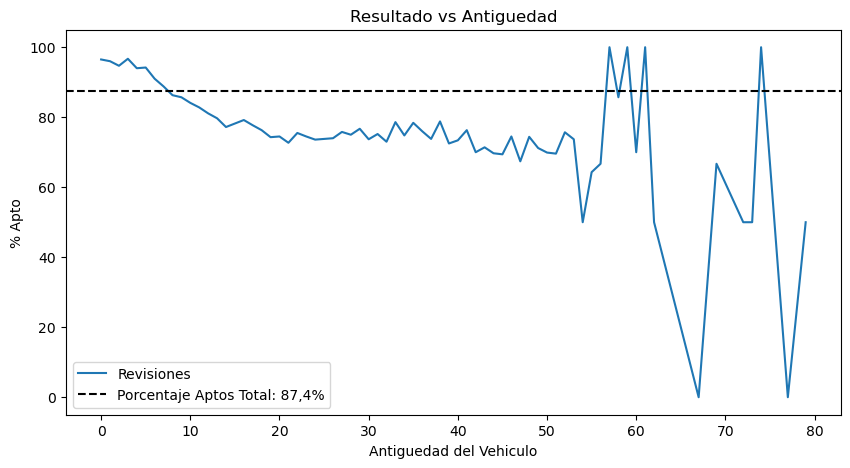

In [1169]:
porc_aptos.plot.line(title='Resultado vs Antiguedad',legend=False,figsize=(10,5))

plt.ylabel('% Apto')
plt.xlabel('Antiguedad del Vehiculo')

plt.axhline(y=aptos_p, color='k', linestyle='--')

plt.legend(labels=['Revisiones','Porcentaje Aptos Total: 87,4%'])


plt.show()

# Revisiones vs patentamientos

In [1174]:
parque_automotor=pd.read_csv('DATASET/Parque_automotor.csv',index_col=0)

In [1175]:
parque_automotor_chaco=parque_automotor[['Anio', 'Mes','CHACO']].copy()

In [1177]:
#parque_autmotor_chaco=pd.DataFrame()
parque_automotor_chaco.head()

,Anio,Mes,CHACO
0,2010,1,127352
1,2010,2,128980
2,2010,3,129745
3,2010,4,130620
4,2010,5,131267


In [1178]:
parque_automotor_chaco.set_index(['Anio', 'Mes'],inplace=True)

In [1179]:
#Revisiones mes a mes 
lista_planillas['Anio y Mes']=lista_planillas['Anio y Mes'].astype('Int64')

revisiones_mes_a_mes=lista_planillas.groupby(['Anio','Mes'])[['Dominio']].count()

revisiones_mes_a_mes.sort_values(['Anio','Mes'],ascending=[True,True])

Dominio
Anio Mes         
2014 10       865
     11      1571
     12      1757
2015 1       2111
     2       1565
...           ...
2022 8       1948
     9       2030
     10      1866
     11      1957
     12      2269

[99 rows x 1 columns]

In [1180]:
test=parque_automotor_chaco.join(revisiones_mes_a_mes,how='left')
test.dropna(subset='Dominio',inplace=True)
test['Porcentaje_vehiculos_revisados']=((test['Dominio']/test['CHACO'])*100).round(2)

In [1181]:
test

CHACO  Dominio  Porcentaje_vehiculos_revisados
Anio Mes                                                 
2014 10   191135    865.0                            0.45
     11   191888   1571.0                            0.82
     12   192373   1757.0                            0.91
2015 1    193789   2111.0                            1.09
     2    194733   1565.0                            0.80
...          ...      ...                             ...
2022 8    283480   1948.0                            0.69
     9    284121   2030.0                            0.71
     10   284712   1866.0                            0.66
     11   285333   1957.0                            0.69
     12   285527   2269.0                            0.79

[99 rows x 3 columns]

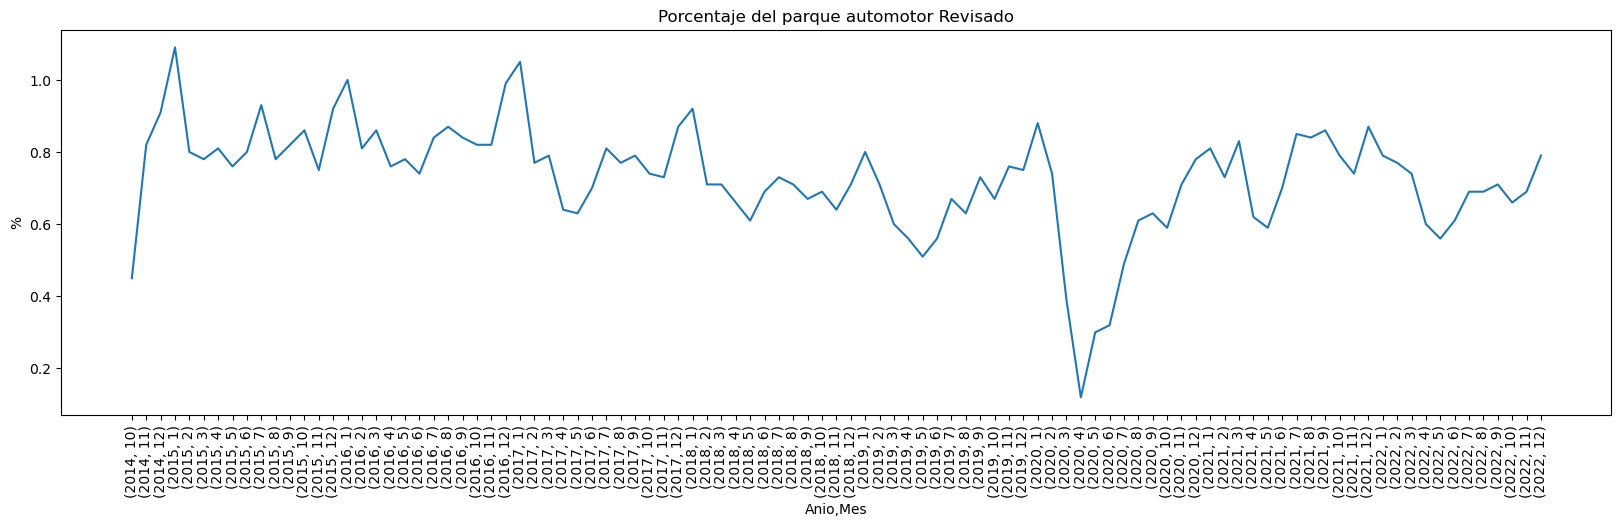

In [1182]:

test['Porcentaje_vehiculos_revisados'].plot(kind='line',
                                            title='Porcentaje del parque automotor Revisado',
                                           figsize=(20,5))

plt.ylabel('%')
plt.xticks(range(len(test.index)), test.index,)
plt.xticks(rotation=90)
plt.show()

In [1183]:
test_año=test.reset_index()

In [1184]:
test_año_graph=test_año.groupby('Anio').sum()[['CHACO','Dominio','Porcentaje_vehiculos_revisados']]

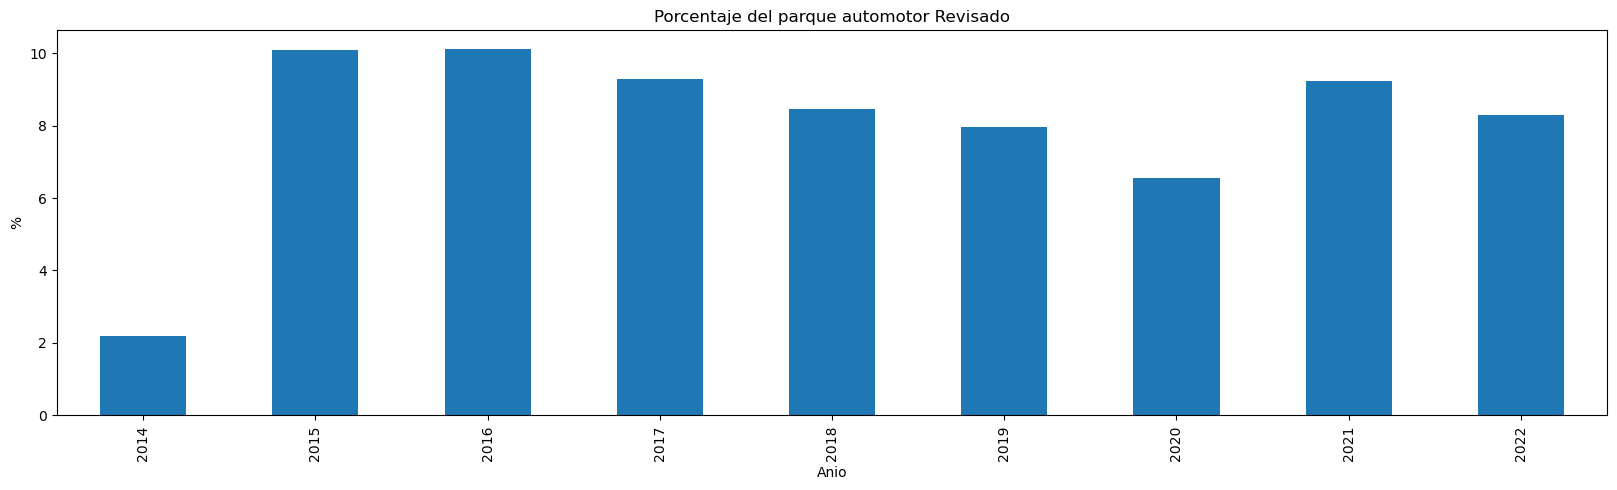

In [1186]:

test_año_graph['Porcentaje_vehiculos_revisados'].plot(kind='bar',
                                            title='Porcentaje del parque automotor Revisado',
                                           figsize=(20,5))

plt.ylabel('%')
#plt.xticks(range(len(test_año_graph.index)), test_año_graph.index,)
plt.xticks(rotation=90)
plt.show()

## Tablas para  Exportar y Visualizar en power  BI 

In [ ]:
path=r'E:\Ordenado\DATA ANALISYS\RTO tablas resultados'

KPI : Revisiones por dia-mes

In [ ]:
# Agregar columna tipo de revision (  Carga - Pasajeros- Particular )
tipo_revision_dic={'M1':'Pasajeros',
                   'M2':'Pasajeros',
                   'M3':'Pasajeros',
                   'N1':'Carga',
                   'N2':'Carga',
                   'N3':'Carga',
                   'O2':'Carga',
                   'O3':'Carga',
                   'O4':'Carga' ,
                   'UP':'Particular'}

lista_planillas['Tipo_Revision']=lista_planillas['Categoría'].map(tipo_revision_dic)

In [ ]:
revisiones_por_dia=lista_planillas.pivot_table(index=('Fecha','Línea'),
                                               columns='Tipo_Revision',
                                               values='Dominio',
                                               aggfunc='count')

In [601]:
# To csv 
revisiones_por_dia.to_csv(path+'/revisiones_por_dia.csv',encoding='latin1')

Revisiones por mes (Objetivo)

In [460]:
revisiones_por_mes=lista_planillas.pivot_table(index=('Mes'),
                                               columns='Anio',
                                               values='Dominio',
                                               aggfunc='count')

In [461]:
revisiones_por_mes['Objetivo']=revisiones_por_mes.max(axis=1)

In [541]:
# Write obj in every year
monthly_obj=revisiones_por_mes.copy()
for i in (range(0,12)):
    
    monthly_obj.iloc[i]=monthly_obj.iloc[[i],[-1]]

In [542]:
monthly_obj.drop('Objetivo',axis=1,inplace=True)


In [543]:
monthly_obj_temp=monthly_obj.unstack()

In [544]:
monthly_obj=monthly_obj_temp.to_frame(name='monthly_obj')

In [545]:
monthly_obj.reset_index(inplace=True)

In [546]:
monthly_obj['Fecha']=monthly_obj['Mes' ].astype('str')+'-1-'+monthly_obj['Anio'].astype('str')

In [547]:
monthly_obj=monthly_obj[['Fecha','monthly_obj']]

In [599]:
# To csv 
monthly_obj.to_csv(path+'/monthly_obj.csv',encoding='latin1')

Revisiones por hora 

In [567]:
test=lista_planillas[['Inicio','Fin','Dominio','Fecha']].copy()
#Cambiar hora_resultado a formato datetime
test['Fin1']=pd.to_datetime(test['Fin'],format="%H:%M")
test['hora']=test['Fin1']
test.set_index('hora',inplace=True)
group=test.resample('1h').count()[['Dominio']]


In [588]:
rev_por_hora=lista_planillas[['Fecha','Fin','Dominio',]].copy()

In [589]:
rev_por_hora['Fin']=pd.to_datetime(rev_por_hora['Fin'],format="%H:%M").dt.hour


In [594]:
rev_por_hora=rev_por_hora.groupby(['Fecha','Fin']).count()

In [598]:
# To csv 
rev_por_hora.to_csv(path+'/rev_por_hora.csv',encoding='latin1')

Resultados de las revisiones

In [612]:
resultados=lista_planillas.pivot_table(index='Fecha',
                                        columns='Resultado',
                                        values='Dominio',
                                        aggfunc='count')

In [614]:
# To csv 
resultados.to_csv(path+'/resultados_revisiones.csv',encoding='latin1')

Retencion Clientes

In [677]:
filtro_taller=retencion_clientes['Taller']==4
filtro_fecha=retencion_clientes['Fecha']>'2014-1-1'

retencion_clientes_4=retencion_clientes[filtro_taller&filtro_fecha]

retencion_clientes_pivot=retencion_clientes_4.pivot_table(index='Fecha',
                                columns='Retencion_cliente',
                                values='Dominio',
                                aggfunc='count')
retencion_clientes_mes=retencion_clientes_pivot.resample("M") .sum() 


In [678]:
retencion_clientes_last_month=retencion_clientes_mes.shift(periods=1)


In [679]:
retencion_clientes_merged=retencion_clientes_mes.join(retencion_clientes_last_month,how='left',rsuffix='_last_month')

In [680]:
# To csv 
retencion_clientes_merged.to_csv(path+'/retencion_clientes.csv',encoding='latin1')

Mejores Clientes Mes

In [1120]:
#Tabla pivot usando pd.grouper para agrupar mensualmente en la columna FECHA
vehiculos_por_cliente_mensual=pd.pivot_table(lista_planillas,
                                             index=(pd.Grouper(key='Fecha',freq='M'),'Razón Social Unica'),
                                             values='Dominio',
                                             aggfunc='count')


In [1128]:
#Anonimizar la tabla:
vehiculos_por_cliente_mensual.reset_index(inplace=True)
anon(vehiculos_por_cliente_mensual,'Razón Social Unica')
vehiculos_por_cliente_mensual.set_index(['Fecha','Razón Social Unica' ],inplace=True)

vehiculos_por_cliente_mensual.drop(columns='index',inplace=True)

In [1129]:
# To csv 
vehiculos_por_cliente_mensual.to_csv(path+'/vehiculos_por_cliente_mensual.csv',encoding='latin1')

Anomalias mas comunes

In [805]:
#Agregar fechas a la tabla de anomalias
planilla_anomalias_fecha=planilla_anomalias.merge(lista_planillas[['Planilla','Fecha']],
                                                  how='left',
                                                  left_on='Planilla',
                                                  right_on='Planilla')

In [813]:
# Remove white Spaces
planilla_anomalias_fecha['Categoria']=planilla_anomalias_fecha['Categoria'].str.strip()

# Remove periods

planilla_anomalias_fecha['Categoria']=planilla_anomalias_fecha['Categoria'].str.replace(".","",regex=False)

# Remove dashes

planilla_anomalias_fecha['Categoria']=planilla_anomalias_fecha['Categoria'].str.replace("-"," ",regex=False)
planilla_anomalias_fecha['Categoria']=planilla_anomalias_fecha['Categoria'].str.replace("–"," ",regex=False)



In [814]:
# Dict of replacements for categories that are the same but written differently 
cat_replacemet={"letreros e indicaciones":"letreros e indicadores",
               "otras anomalias (ingrese descripción en la columna observación del sistema rtocent)":"otras anomalias",
               "sistema de arrastre de acoplados y dolly":"sistema de arrastre para acoplados",
                "tren delantero, trasero, suspensión" :	"tren delantero, tren trasero, suspensión"
                }

In [815]:
planilla_anomalias_fecha['Categoria']=planilla_anomalias_fecha['Categoria'].replace(cat_replacemet)

In [821]:
#Tabla pivot usando pd.grouper para agrupar mensualmente en la columna FECHA
planilla_anomalias_mes=pd.pivot_table(planilla_anomalias_fecha,
                                      index=(pd.Grouper(key='Fecha',freq='M'),'Categoria','Gravedad'),
                                      values='Planilla',
                                      aggfunc='count')

In [822]:
# To csv 
planilla_anomalias_mes.to_csv(path+'/planilla_anomalias_mes.csv')

Antiguedad y % aprobado

In [853]:
#eliminar anulados
test=lista_planillas[lista_planillas['Resultado']!='Anulado'].copy()

resultados_por_antiguedad=pd.crosstab(test['antiguedad_revision'],
                                      test['Resultado'],
                                      test['Dominio'],
                                      aggfunc='count',
                                     normalize='index')

In [854]:
resultados_por_antiguedad=(resultados_por_antiguedad*100).round(2)

In [855]:
# To csv 
resultados_por_antiguedad.to_csv(path+'/resultados_por_antiguedad.csv')

Revisiones Provincia

In [874]:
parque_automotor_chaco=parque_automotor[['Anio', 'Mes','CHACO']].copy()

In [875]:
parque_automotor_chaco['Fecha']=parque_automotor_chaco['Anio'].astype('str')+'-'+parque_automotor_chaco['Mes'].astype('str')+'-1'

parque_automotor_chaco['Fecha'] = pd.to_datetime(parque_automotor_chaco['Fecha'], format="%Y/%m/%d")

In [876]:
revisiones_prov=parque_automotor_chaco[['Fecha','CHACO']].copy()

In [877]:
# To csv 
revisiones_prov.to_csv(path+'/revisiones_prov.csv')

test faker 

In [878]:
#Tabla pivot usando pd.grouper para agrupar mensualmente en la columna FECHA
vehiculos_por_cliente_mensual=pd.pivot_table(lista_planillas,
                                             index=(pd.Grouper(key='Fecha',freq='M'),'Razón Social Unica'),
                                             values='Dominio',
                                             aggfunc='count')

In [889]:
#Tabla pivot usando pd.grouper para agrupar mensualmente en la columna FECHA
vehiculos_por_cliente_mensual=pd.pivot_table(lista_planillas,
                                             index=(pd.Grouper(key='Fecha',freq='M'),'nickname'),
                                             values='Dominio',
                                             aggfunc='count')